In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
%matplotlib inline

housing = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

In [2]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include = ['integer','float'])
    numeric_test = train.select_dtypes(include = ['integer','float'])
    features = numeric_train.columns.drop('SalePrice')
    
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

In [3]:
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.251612639091

# Feature Engineering
1: Drop any column with 5% or more missing values:

In [4]:
# Tally the total missing values for each column
missing_val = housing.isnull().sum()
missing_val

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

In [5]:
# Selects columns with missing values in excess of 5%
drop_missing_col = missing_val[(missing_val > len(housing)*0.05)].sort_values()
# Drop the selected columns from the housing data
housing = housing.drop(drop_missing_col.index, axis=1)

In [6]:
housing.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Area            0
Street              0
Lot Shape           0
Land Contour        0
Utilities           0
Lot Config          0
Land Slope          0
Neighborhood        0
Condition 1         0
Condition 2         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type       23
Mas Vnr Area       23
Exter Qual          0
Exter Cond          0
Foundation          0
Bsmt Qual          80
                   ..
Electrical          1
1st Flr SF          0
2nd Flr SF          0
Low Qual Fin SF     0
Gr Liv Area         0
Bsmt Full Bath      2
Bsmt Half Bath      2
Full Bath           0
Half Bath           0
Bedroom AbvGr       0
Kitchen AbvGr       0
Kitchen Qual        0
TotRms AbvGrd       0
Functional          0
Fireplaces

2: Drop any text column missing 1 or more values

In [7]:
# Tally the total missing values from the text columns
text_missing = housing.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
# Select the columns that are missing at least one value
drop_missing_col_2 = text_missing[text_missing > 0]

housing = housing.drop(drop_missing_col_2.index, axis = 1)

3: For numerical columns, fill in missing values with the most common value for each column

In [8]:
num_missing = housing.select_dtypes(include=['int','float']).isnull().sum()
num_missing_fix = num_missing[(num_missing < len(housing)/20) & (num_missing > 0)].sort_values()
num_missing_fix

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [9]:
# Determine the most common value in each column
fill_val = housing[num_missing_fix.index].mode().to_dict(orient='records')[0]
fill_val

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [10]:
# Replace the missing values with pd.Dataframe.fillna()
housing = housing.fillna(fill_val)

In [11]:
# Confirm missing values are absent
housing.isnull().sum().value_counts()

0    64
dtype: int64

* What new features can we create, that better capture the information in some of the features?

In [12]:
# Compute how many years have passed from when the house was built to
# it being initially sold
years_sold = housing['Yr Sold'] - housing['Year Built']
# Check for any negative values (i.e. incorrect dates)
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [13]:
# Compute how many years have passed from when the house was remodeled to
# when it was next sold
years_since_remod = housing['Yr Sold'] - housing['Year Remod/Add']
# Check for any negative values
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [14]:
# Add new columns based on computations
housing['Years Before Sale'] = years_sold
housing['Years Since Remodel'] = years_since_remod

# Drop rows with negative values and original years columns
housing = housing.drop([1702,2180,2181], axis=0)
housing = housing.drop(['Year Built', 'Year Remod/Add'], axis=1)

Drop columns that are not useful for machine learning and ones that leak data about the final sale.

In [15]:
# Columns not useful to machine learning
housing = housing.drop(['PID', 'Order'], axis=1)
# Columns that leak data about the finale sale
housing = housing.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

* Update `transform_features()` to incorporate the previous transformations

In [16]:
def transform_features(df):
    missing_val = df.isnull().sum()
    drop_missing_col = missing_val[(missing_val > len(df)*0.05)].sort_values()
    df = df.drop(drop_missing_col.index, axis=1)
    
    text_missing = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_col_2 = text_missing[text_missing > 0]
    df = df.drop(drop_missing_col_2.index, axis = 1)
    
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    num_missing_fix = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    
    fill_val = df[num_missing_fix.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_val)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remodel'] = years_since_remod
    df = df.drop([1702,2180,2181], axis=0)
    df = df.drop(['Year Built','Year Remod/Add','PID','Order','Mo Sold','Sale Condition','Sale Type','Yr Sold'], axis=1)
    
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include = ['integer','float'])
    numeric_test = train.select_dtypes(include = ['integer','float'])
    features = numeric_train.columns.drop('SalePrice')
    
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

housing = pd.read_csv('AmesHousing.tsv', delimiter='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413073

The initial execution of the train and test yielded a result of `57088.2516`  and after tailoring the features to best fit the model, the RMSE result has been decreased to `55275.3673`.

# Feature Selection for Numerical Values

In [17]:
numerical_df = transform_df.select_dtypes(include=['int','float'])
abs_corrs_coeff = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corrs_coeff

BsmtFin SF 2           0.006127
Misc Val               0.019273
3Ssn Porch             0.032268
Bsmt Half Bath         0.035875
Low Qual Fin SF        0.037629
Pool Area              0.068438
MS SubClass            0.085128
Overall Cond           0.101540
Screen Porch           0.112280
Kitchen AbvGr          0.119760
Enclosed Porch         0.128685
Bedroom AbvGr          0.143916
Bsmt Unf SF            0.182751
Lot Area               0.267520
2nd Flr SF             0.269601
Bsmt Full Bath         0.276258
Half Bath              0.284871
Open Porch SF          0.316262
Wood Deck SF           0.328183
BsmtFin SF 1           0.439284
Fireplaces             0.474831
TotRms AbvGrd          0.498574
Mas Vnr Area           0.506983
Years Since Remodel    0.534985
Full Bath              0.546118
Years Before Sale      0.558979
1st Flr SF             0.635185
Garage Area            0.641425
Total Bsmt SF          0.644012
Garage Cars            0.648361
Gr Liv Area            0.717596
Overall 

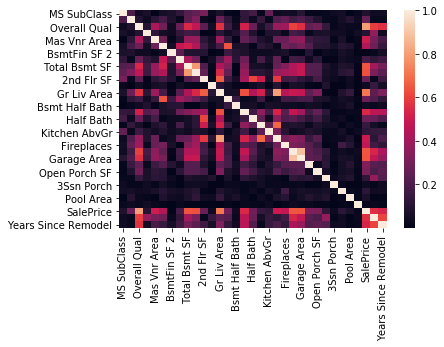

In [18]:
import seaborn as sns
sns.heatmap(numerical_df.corr().abs())

In [19]:
# Focus on features with a correlation greater than 40%
abs_corrs_coeff[abs_corrs_coeff > 0.4]

BsmtFin SF 1           0.439284
Fireplaces             0.474831
TotRms AbvGrd          0.498574
Mas Vnr Area           0.506983
Years Since Remodel    0.534985
Full Bath              0.546118
Years Before Sale      0.558979
1st Flr SF             0.635185
Garage Area            0.641425
Total Bsmt SF          0.644012
Garage Cars            0.648361
Gr Liv Area            0.717596
Overall Qual           0.801206
SalePrice              1.000000
Name: SalePrice, dtype: float64

In [20]:
# Drop columns with less than 40% correlation to SalePrice
transform_df = transform_df.drop(abs_corrs_coeff[abs_corrs_coeff > 0.4].index, axis = 1)

In [21]:
# Select the columns from the documentation which are marked 'nominal' that
# will be converted to categorical data type
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

* Check the columns currently in the dataframe that are numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)
* Check which categorical columns should be used to avoid having hundreds of columns added after adding dummy code.

In [22]:
# Check which categorical columns are already present in the dataframe
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)
        
# Compute how many unique values are in each categorical column
unique_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
unique_counts

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [23]:
# Drop columns with more than 10 unique values (arbitrary cutoff)
drop_unique_cols = unique_counts[unique_counts > 10].index
transform_df = transform_df.drop(drop_unique_cols, axis = 1)

In [24]:
# Convert the remaining text columns to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
# Create dummy columns that get added back to the dataframe
transform_df = pd.concat([
    transform_df,
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis = 1)

* Update `select_features()` to incorporate these new feature selection methods

In [25]:
def transform_features(df):
    missing_val = df.isnull().sum()
    drop_missing_col = missing_val[(missing_val > len(df)*0.05)].sort_values()
    df = df.drop(drop_missing_col.index, axis=1)
    
    text_missing = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_col_2 = text_missing[text_missing > 0]
    df = df.drop(drop_missing_col_2.index, axis = 1)
    
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    num_missing_fix = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    
    fill_val = df[num_missing_fix.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_val)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remodel'] = years_since_remod
    df = df.drop([1702,2180,2181], axis=0)
    df = df.drop(['Year Built','Year Remod/Add','PID','Order','Mo Sold','Sale Condition','Sale Type','Yr Sold'], axis=1)
    
    return df

def select_features(df, coeff_threshold=0.4, unique_threshold=10):
    numerical_df = df.select_dtypes(include=['int','float'])
    abs_corrs_coeff = numerical_df.corr()['SalePrice'].abs().sort_values()
    
    df = df.drop(abs_corrs_coeff[abs_corrs_coeff > coeff_threshold].index, axis = 1)
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
        
    unique_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_unique_cols = unique_counts[unique_counts > 10].index
    df = df.drop(drop_unique_cols, axis = 1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    
    df = pd.concat([
        transform_df,
        pd.get_dummies(df.select_dtypes(include=['category']))
    ], axis = 1)
    
    return df

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include = ['integer','float'])
    numeric_test = train.select_dtypes(include = ['integer','float'])
    features = numeric_train.columns.drop('SalePrice')
    
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
    return rmse

housing = pd.read_csv('AmesHousing.tsv', delimiter='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

56839.72631923257

* Update `train_and_test()` to include parameter `k` that controls the type of cross validation that occurs

In [26]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    # When k=0, perform holdout validation (already implemented earlier)
    if k==0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    
        return rmse
    
    # When k=1, peform simple cross validation
    if k==1:
        # Randomize all rows from df and return
        df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions_one = lr.predict(test[features])
        rmse_one = np.sqrt(mean_squared_error(test['SalePrice'], predictions_one))
        
        lr.fit(test[features], test['SalePrice'])
        predictions_two = lr.predict(train[features])
        rmse_two = np.sqrt(mean_squared_error(train['SalePrice'], predictions_two))
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
            rmse_values.append(rmse)
        
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

housing = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

28049.424483049821